# Przygotowanie danych treningowych

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from pathlib import Path


train_data_root = Path('/content/drive/MyDrive/data/sunflowers')

# Użyteczne zależności

In [ ]:
!pip install -U torch torchvision pytorch-lightning torchmetrics segmentation-models-pytorch albumentations monai

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 720.6/720.6 kB 42.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 48.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.7/125.7 kB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 82.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 9.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 106.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 31.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 84.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 65.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━

# Przykładowy trening

In [ ]:
import torch
import numpy as np

from typing import List, Tuple
from pathlib import Path
from PIL import Image

import albumentations as A


class ImagesDataset(torch.utils.data.Dataset):
    def __init__(self, base_path: Path, images_names: List[str],
                 transforms: A.Compose):
        super().__init__()

        self._base_path = base_path
        self._images_names = images_names
        self._transforms = transforms

    def __len__(self) -> int:
        return len(self._images_names)

    def __getitem__(self, index: int) -> Tuple[torch.Tensor, torch.Tensor]:
        image_name = self._images_names[index]

        image = np.asarray(Image.open(self._base_path / 'images' / image_name))
        mask = np.asarray(Image.open(self._base_path / 'masks' / f'{image_name[:-4]}.png')) / 255

        transformed = self._transforms(image=image, mask=mask)

        return transformed['image'], transformed['mask'][None, ...].float()

In [ ]:
import shutil
import pytorch_lightning as pl

from pathlib import Path
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader, random_split
from sklearn.model_selection import train_test_split

from albumentations.pytorch import ToTensorV2


class SegmentationDataModule(pl.LightningDataModule):
  def __init__(self, data_dir: Path = Path('/content/drive/MyDrive/data/sunflowers'), batch_size: int = 16):
    super().__init__()

    self.data_dir = data_dir
    self.batch_size = batch_size
    self.augmentations = A.Compose([
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.RandomCrop(height=512, width=512),
        A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        A.RandomBrightnessContrast(p=0.3),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2()
    ])
    self.transforms = A.Compose([
        A.CenterCrop(height=512, width=512),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2()
    ])

  def setup(self, stage: str):
    images_names = [image_path.name
                    for image_path in sorted((self.data_dir / 'images').iterdir())]

    train_images_names, val_images_names = train_test_split(images_names,
                                                            test_size=0.15,
                                                            random_state=42)
    self.train_dataset = ImagesDataset(self.data_dir, train_images_names,
                                       self.augmentations)
    self.val_dataset = ImagesDataset(self.data_dir, val_images_names,
                                     self.transforms)

  def train_dataloader(self):
    return DataLoader(self.train_dataset, batch_size=self.batch_size)

  def val_dataloader(self):
    return DataLoader(self.val_dataset, batch_size=self.batch_size)

  def test_dataloader(self):
    return DataLoader(self.val_dataset, batch_size=self.batch_size)

In [ ]:
import pytorch_lightning as pl

from torch import nn
from torchmetrics import MetricCollection, classification
from segmentation_models_pytorch import Unet
from segmentation_models_pytorch.losses import DiceLoss

val_losses = []
train_losses = []
train_acc = []
val_acc = []
class Segmenter(pl.LightningModule):
    def __init__(self):
        super().__init__()

        self.network = Unet('vgg13')

        self.loss = DiceLoss('binary', from_logits=True)

        metric_collection = MetricCollection([
            classification.BinaryF1Score(),
            classification.BinaryPrecision(),
            classification.BinaryRecall()
        ])
        self.train_metrics = metric_collection.clone('train_')
        self.val_metrics = metric_collection.clone('val_')
        self.test_metrics = metric_collection.clone('test_')

    def forward(self, x):
        return self.network(x)

    def training_step(self, batch, batch_idx):
        inputs, targets = batch
        preds = self(inputs)
        loss = self.loss(preds, targets)
        train_losses.append(loss.item())
        acc = self.train_metrics(preds, targets)
        self.log_dict(acc)
        train_acc.append(acc)
        return loss

    def validation_step(self, batch, batch_idx):
        inputs, targets = batch
        preds = self(inputs)
        loss = self.loss(preds, targets)
        val_losses.append(loss.item())
        self.log('val_loss', loss)
        acc = self.val_metrics(preds, targets)
        self.log_dict(acc, prog_bar=True)
        val_acc.append(acc)


    def test_step(self, batch, batch_idx):
        inputs, targets = batch
        preds = self(inputs)
        loss = self.loss(preds, targets)

        self.log('test_loss', loss)
        self.log_dict(self.test_metrics(preds, targets))

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=3e-4)

In [ ]:
datamodule = SegmentationDataModule()
model = Segmenter()

checkpoint_callback = pl.callbacks.ModelCheckpoint(
    filename='{epoch}-{val_loss:.3f}',
    verbose=True
)
early_stopping_callback = pl.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=15,
    verbose=True
)

trainer = pl.Trainer(accelerator='gpu',
                     devices=1,
                     callbacks=[checkpoint_callback, early_stopping_callback],
                     max_epochs=1000)
trainer.fit(model, datamodule=datamodule)

Downloading: "https://download.pytorch.org/models/vgg13-c768596a.pth" to /root/.cache/torch/hub/checkpoints/vgg13-c768596a.pth
100%|██████████| 508M/508M [00:08<00:00, 62.1MB/s]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | network       | Unet             | 18.4 M
1 | loss          | DiceLoss         | 0     
2 | train_metrics | MetricCollection | 0     
3 | val_metrics   | MetricCollection | 0     
4 | test_metrics  | MetricCollection | 0     
---------------------------------------

Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved. New best score: 0.747


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.059 >= min_delta = 0.0. New best score: 0.688


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.042 >= min_delta = 0.0. New best score: 0.646


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.032 >= min_delta = 0.0. New best score: 0.613


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.063 >= min_delta = 0.0. New best score: 0.551


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.025 >= min_delta = 0.0. New best score: 0.526


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.067 >= min_delta = 0.0. New best score: 0.459


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.014 >= min_delta = 0.0. New best score: 0.446


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 0.434


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.050 >= min_delta = 0.0. New best score: 0.384


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.019 >= min_delta = 0.0. New best score: 0.365


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.037 >= min_delta = 0.0. New best score: 0.328


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.324


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.016 >= min_delta = 0.0. New best score: 0.307


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.041 >= min_delta = 0.0. New best score: 0.267


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.017 >= min_delta = 0.0. New best score: 0.250


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.244


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.028 >= min_delta = 0.0. New best score: 0.216


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.209


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.014 >= min_delta = 0.0. New best score: 0.195


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.186


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.181


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.014 >= min_delta = 0.0. New best score: 0.167


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 0.155


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.148


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.141


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.135


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.017 >= min_delta = 0.0. New best score: 0.118


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.117


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.113


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Monitored metric val_loss did not improve in the last 15 records. Best score: 0.113. Signaling Trainer to stop.


In [ ]:
trainer.test(model, datamodule=datamodule, ckpt_path='best')

INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/lightning_logs/version_0/checkpoints/epoch=117-val_loss=0.113.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at /content/lightning_logs/version_0/checkpoints/epoch=117-val_loss=0.113.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    test_BinaryF1Score     │    0.8984454274177551     │
│   test_BinaryPrecision    │    0.8962894082069397     │
│     test_BinaryRecall     │    0.9006117582321167     │
│         test_loss         │    0.1127767562866211     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.1127767562866211,
  'test_BinaryF1Score': 0.8984454274177551,
  'test_BinaryPrecision': 0.8962894082069397,
  'test_BinaryRecall': 0.9006117582321167}]

## Wykres straty

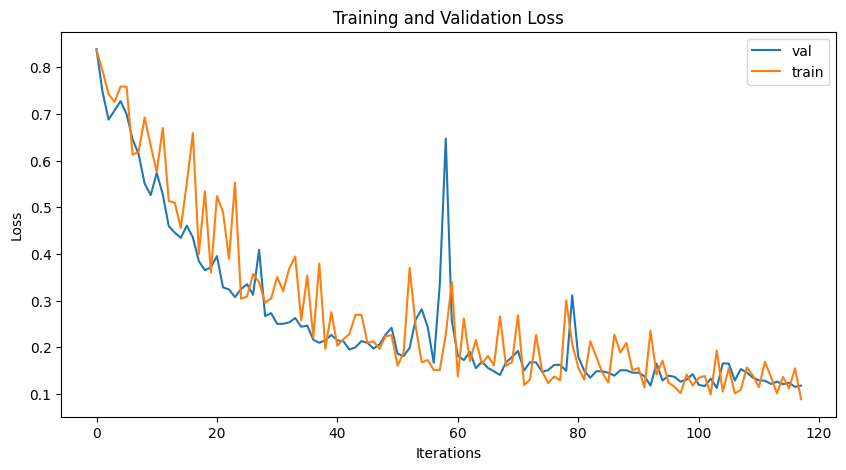

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss")
plt.plot(val_losses[:-1], label="val")
plt.plot(train_losses[::3], label="train")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

## Wykres Precyzji

In [ ]:
val_binary_precision = []
for item in val_acc:
    precision = item['val_BinaryPrecision'].item()
    val_binary_precision.append(precision)

train_binary_precision = []
for item in train_acc:
    precision = item['train_BinaryPrecision'].item()
    train_binary_precision.append(precision)

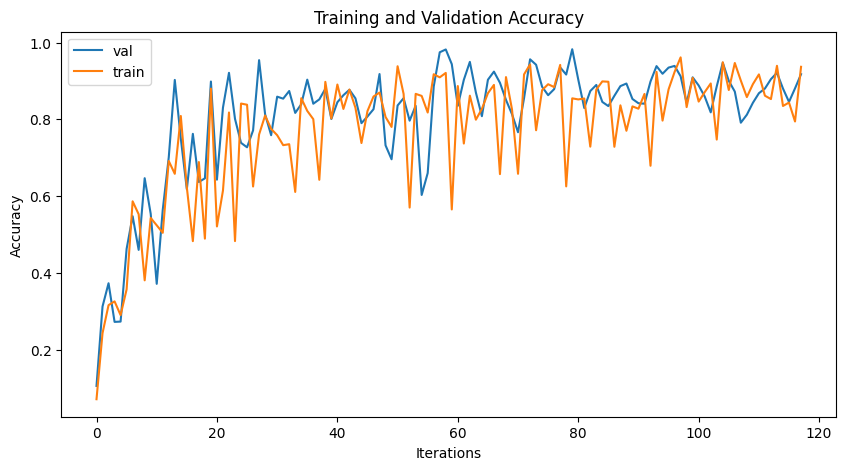

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10,5))
plt.title("Training and Validation Accuracy")
plt.plot(val_binary_precision[:-1], label="val")
plt.plot(train_binary_precision[::3], label="train")
plt.xlabel("Iterations")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Ewaluacja

## Predykcja dla wszystkich zdjęć ze zbioru testowego

In [ ]:
test_images_path = Path('/content/drive/MyDrive/test')
predictions_path = Path('/content/predictions')
predictions_path.mkdir(exist_ok=True)

In [ ]:
import numpy as np

from PIL import Image
from monai.inferers import sliding_window_inference
from tqdm import tqdm

model = Segmenter.load_from_checkpoint(checkpoint_callback.best_model_path)
transforms = A.Compose([
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

gpu = torch.device('cuda:0')
cpu = torch.device('cpu')

for image_path in tqdm(list(test_images_path.iterdir())):
  image = np.asarray(Image.open(image_path))
  inputs = transforms(image=image)['image']

  with torch.no_grad():
    outputs = torch.sigmoid(sliding_window_inference(
        inputs=inputs[None, ...],
        roi_size=(512, 512),
        sw_batch_size=32,
        predictor=model.eval().to(gpu),
        overlap=0.5,
        mode='gaussian',
        sw_device=gpu,
        device=cpu
    ))

  outputs = outputs.squeeze().numpy()
  outputs[outputs < 0.5] = 0  # Można wykorzystać inny próg
  outputs[outputs != 0] = 255

  Image.fromarray(outputs.astype(np.uint8)).save(predictions_path / f'{image_path.stem}.png')

100%|██████████| 3/3 [00:13<00:00,  4.62s/it]


## Wyświetlenie przykładowego zdjęcia i predykcji

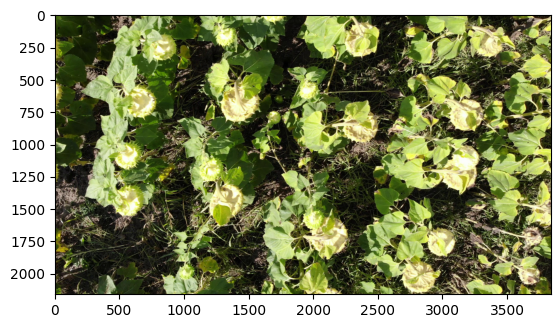

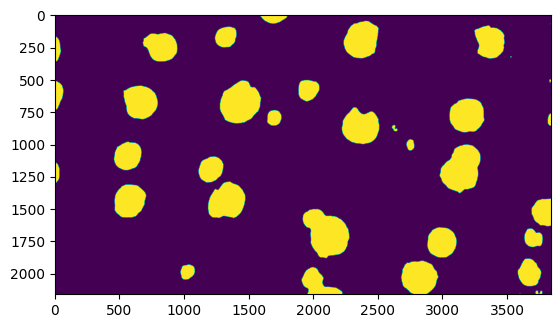

In [ ]:
import matplotlib.pyplot as plt

image = np.asarray(Image.open(test_images_path / 'frame25.jpg'))
prediction = np.asarray(Image.open(predictions_path / 'frame25.png'))

plt.imshow(image)
plt.figure()

plt.imshow(prediction)

## Zapisywanie modelu

In [ ]:
# path_to_save = "PATH_TO_FOLDER_AND_NAME"
# torch.save(model.state_dict(), path_to_save)

## Wczytanie modelu

In [ ]:
# model = Segmenter()
# model.load_state_dict(torch.load("PATH_TO_MODEL"))
# model.eval()